In [1]:
import math
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.stats import skew, kurtosis

In [2]:
start_point = (3800, 3800)
size = (256, 256)

centers = [
    (13, 29), 
    (23, 3), 
    (30, 51), 
    (38, 41), 
    (10, 57), 
    (1, 43),
    (48, 52), 
    (28, 89), 
    (55, 92),
    (59, 25), 
    (69, 3), 
    (46, 3), 
    (91, 42), 
    (116, 51),
    (150, 4), 
    (162, 12),
    (77, 20), 
    (116, 30), 
    (141, 22), 
    (146, 37), 
    (156, 54), 
    (171, 53), 
    (142, 59), 
    (120, 62), 
    (92, 73), 
    (80, 84), 
    (81, 99), 
    (143, 81), 
    (128, 83), 
    (120, 100), 
    (127, 112), 
    (119, 123), 
    (79, 133), 
    (90, 140), 
    (139, 131), 
    (177, 112), 
    (157, 134), 
    (110, 158), 
    (104, 166), 
    (71, 142), 
    (69, 177),
    (68, 194), 
    (96, 201), 
    (60, 211),
    (42, 215),
    (30, 215),
    (154, 150), 
    (156, 166), 
    (254, 103), 
    (239, 117), 
    (239, 65), 
    (245, 12), 
    (239, 3), 
    (250, 44), 
    (255, 24), 
    (243, 82), 
    (216, 181), 
    (253, 128), 
    (188, 150), 
    (181, 178), 
    (141, 177), 
    (176, 197), 
    (126, 190), 
    (4, 177), 
    (29, 239), 
    (26, 255), 
    (143, 207), 
    (158, 210), 
    (167, 223), 
    (171, 211), 
    (189, 218), 
    (249, 179), 
    (233, 176), 
    (229, 243), 
    (2, 212), 
    (9, 251), 
    (128, 227), 
    (115, 243), 
    (199, 195), 
    (244, 227), 
    (204, 240), 
    (178, 227), 
    (194, 252), 
    (252, 246), 
    (256, 234), 
    (44, 256), 
    (94, 241), 
    (79, 245), 
    (89, 254), 
    (64, 255), 
    (246, 199), 
    (208, 217), 
    (189, 239), 
    (172, 236), 
    (158, 232), 
    (183, 253), 
    (171, 251), 
    (151, 251), 
    (135, 255),
    (108, 233)
]

In [3]:
def calculate_radii(points: list):
    n = len(points)
    radii = []
    for i in range(n):
        min_dist = float('inf')
        x1, y1 = points[i]
        
        for j in range(n):
            if i != j:
                x2, y2 = points[j]
                dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                if dist < min_dist:
                    min_dist = dist
        radii.append(min_dist // 2)
    return radii

In [4]:
radii = calculate_radii(centers)

In [5]:
len(radii) == len(centers)

True

In [6]:
img = tifffile.imread('../data/Section6_CODEX.tif')
img = np.transpose(img, (1, 2, 0))
left, top = start_point
width, height = size
right = left + width
bottom = top + height

cropped_image = img[left:right, top:bottom]
cropped_image.shape

(256, 256, 41)

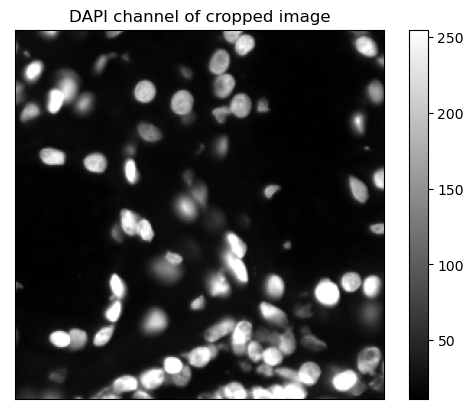

In [7]:
plt.figure()
plt.imshow(cropped_image[:, :, 0], cmap='gray')
plt.title('DAPI channel of cropped image')
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.savefig('./cropped_DAPI_channel.png')
plt.show()

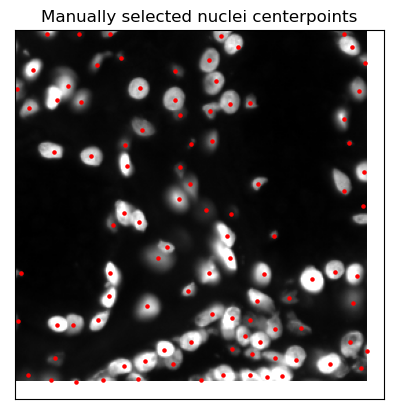

In [8]:
x_pts = [x for x, _ in centers]
y_pts = [y for _, y in centers]

plt.figure()
plt.imshow(cropped_image[:, :, 0], cmap='gray')
plt.scatter(x_pts, y_pts, color='red', s=5)
plt.title('Manually selected nuclei centerpoints')
plt.xticks([]), plt.yticks([])
plt.savefig('./cropped_DAPI_with_nuclei.png')
plt.show()

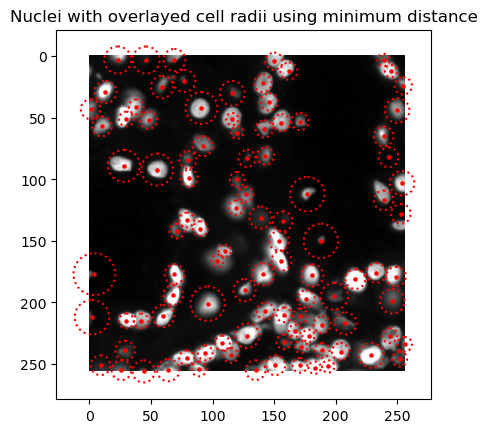

In [9]:
fig, ax = plt.subplots()
ax.imshow(cropped_image[:, :, 0], cmap='gray')
ax.set_title('Nuclei with overlayed cell radii using minimum distance')
for (x, y), radius in zip(centers, radii):
    ax.scatter(x, y, color='red', s=5)
    circle = Circle((x, y), radius, color='red', fill=False, linestyle='dotted', linewidth=1.5)
    ax.add_patch(circle)
plt.savefig('cropped_DAPI_with_nuclei_radii.png')
plt.show()

In [10]:
def crop_and_mask_cell(image, center, radius):
    x_center, y_center = center
    
    x_start = int(max(x_center - radius, 0))
    x_end = int(min(x_center + radius, image.shape[1]))
    y_start = int(max(y_center - radius, 0))
    y_end = int(min(y_center + radius, image.shape[0]))

    
    cropped_image = image[y_start:y_end, x_start:x_end, :]

    y, x = np.ogrid[:y_end - y_start, :x_end - x_start]
    mask = (x - radius)**2 + (y - radius)**2 > radius**2  # Calculate mask
    mask = mask[:, :, np.newaxis]
    extended_mask = np.broadcast_to(mask, cropped_image.shape)
    
    masked_image = np.ma.array(cropped_image, mask=extended_mask)

    return masked_image

In [11]:
def valid_values(masked_array: np.ma.MaskedArray) -> np.ndarray:
    return masked_array[masked_array.mask == False]


def generate_feature_extractors() -> list[callable]:
    methods = [_channelwise_mean,
               _channelwise_stdev,
               _channelwise_median,
               #_channelwise_kurtosis,
               #_channelwise_skewness,
               _max_intensity,
               _min_intensity, 
               _radius]

    #logger.debug(f'Feature extraction methods: {[method.__name__ for method in methods]}')
    return methods


def _channelwise_mean(pixel_values: np.ma.MaskedArray) -> np.ndarray:
    return np.ma.mean(pixel_values, axis=(0, 1))


def _channelwise_stdev(pixel_values: np.ma.MaskedArray) -> np.ndarray:
    return np.ma.std(pixel_values, axis=(0, 1))


def _channelwise_median(pixel_values: np.ma.MaskedArray) -> np.ndarray:
    return np.ma.median(pixel_values, axis=(0, 1))


def _channelwise_skewness(pixel_values: np.ma.MaskedArray) -> np.ndarray:
    channels_skewness = []
    for channel_image in pixel_values:
        channel_values = valid_values(channel_image)
        channel_skew = skew(channel_values.flatten())
        channels_skewness.append(channel_skew)
    return np.array(channels_skewness)


def _channelwise_kurtosis(pixel_values: np.ma.MaskedArray) -> np.ndarray:
    channels_kurtosis = []
    for channel_image in pixel_values:
        channel_values = valid_values(channel_image)
        channel_skew = kurtosis(channel_values.flatten())
        channels_kurtosis.append(channel_skew)
    return np.array(channels_kurtosis)


def _min_intensity(pixel_values: np.ma.MaskedArray) -> np.ndarray:
    return np.ma.min(pixel_values, axis=(0, 1))


def _max_intensity(pixel_values: np.ma.MaskedArray) -> np.ndarray:
    return np.ma.max(pixel_values, axis=(0, 1))


def _radius(pixel_values):
    return pixel_values.shape[0] // 2

In [12]:
feature_extractors = generate_feature_extractors()
features = []
for center, radius in zip(centers, radii):
    pixel_values = crop_and_mask_cell(cropped_image, center, radius)
    features.append([feature_extractor(pixel_values) for feature_extractor in feature_extractors])

In [13]:
features_list = []
for cell_features in features:
    cell_features_list = []
    for extractor_value in cell_features:
        if type(extractor_value) == int:
            cell_features_list.append(extractor_value)
        else:
            cell_features_list.extend(list(extractor_value))
    features_list.append(cell_features_list)

In [14]:
features_array = np.array(features_list)

In [15]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from typing import Union

def dimensionality_reduction(features: np.ndarray, num_components: Union[int, None] = None) -> np.ndarray:
    pca = PCA(n_components=num_components)
    reduced_features = pca.fit_transform(features)  # reduce dimensionality
    return reduced_features

In [16]:
reduced_features = dimensionality_reduction(features_array, num_components=20)

In [17]:
kmeans = KMeans(n_clusters=10, n_init='auto')

In [18]:
predictions = kmeans.fit_predict(reduced_features)

In [19]:
predictions = list(predictions)

In [20]:
len(predictions)

100

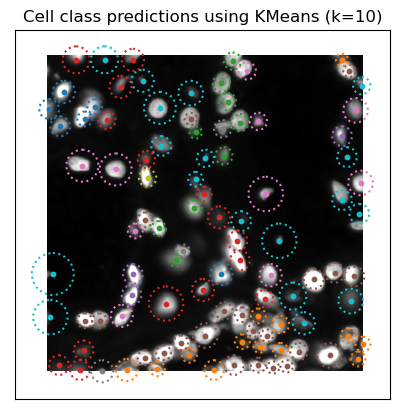

In [21]:
from matplotlib.cm import get_cmap

fig, ax = plt.subplots()
ax.imshow(cropped_image[:, :, 0], cmap='gray')
ax.set_title('Cell class predictions using KMeans (k=10)')
cmap = get_cmap('tab10')
ax.set_xticks([]), ax.set_yticks([])

for (x, y), radius, cls, in zip(centers, radii, predictions):
    color = cmap(cls % 10)
    ax.scatter(x, y, color=color, s=10)
    circle = Circle((x, y), radius, color=color, fill=False, linestyle='dotted', linewidth=1.5)
    ax.add_patch(circle)
    
plt.savefig('./cropped_DAPI_with_predictions.png')
plt.show()

In [23]:
features_array.shape

(100, 206)